## MATH-253 homework 7
## Grace Yang
## gy654
## N10610063

## Problem 1
Let $A \in R^{m\times n}, x \in R^{n}$, and $b \in R^{m}$, where $m<n$. In general, undetermined linear systems admit either no solution, or infinitely many solutions. For instance, if our goal is to find some $x$ satisfying $Ax=b$, and we try to solve the least square problem:
$$\text{minimize} \quad ||Ax-b||_{2}^{2}$$
we run into trouble with the pseudoinverse $A^{\dagger} = (A^TA)^{-1}A^T$, since $A^TA$ us rank deficient(why?). The sandard way to get around this problem is to regularize the problem. As you saw in the midterm, if you instead solve the regularized least square problem: 
$$\text{minimize} \quad ||Ax-b||_{2}^{2} + \sigma ||x||_{2}^{2}$$ 
where $\sigma >0$
Download the Nile time series data set `nile.csv`. The first column is the year and the second column is the river flow. Load this data set into numpy and eliminate some values (e.g. assume 10 entries in the middle of the time series are missing). We will try to use a discrete cosine transform (DCT) basis to recover the missing values. Let $n$ be the number of points in the time series, and use the following code:
`X = scipy.fft.dct(n, norm = 'ortho')` to create an orthogonal DCT matrix. Note that the columns of $X$ will correspond to cosines of progressively higher frequency (you can plot a few to see). Let $f$ be the vector of flow rates. Then $\alpha = X^{-1}f = X^Tf$ gives the coefficients of $f$ in the DCT basis. 
Let $I$ be an index vector giving non-missing values of the time series. Then $X_1 \in R^{|I| \times n}$ restricts the columns of the DCT matrix to those known values. The linear system $X_{I}\alpha = f_{I}$ is an underdetermined linear system. Try to solve this problem using least squares and regularized least squares. Plot the resulting flow rate versus the year. Does this do a good job of filling in the missing values? Dies $L_2$ regularization help? Explain your findings. 

In [7]:
import numpy as np
import scipy
import scipy.fft as fft
import pandas as pd
from numpy.linalg import inv
import random
import matplotlib.pyplot as plt
from scipy.optimize import linprog
import warnings
warnings.filterwarnings("ignore")

In [8]:

file_path = './nile.csv'
n_missing = 10
mask = list(set(random.sample(set(range(100)),n_missing)))
reverse_mask = list(set(range(100)) - set(mask))
nile_data = np.genfromtxt(file_path, delimiter=',')[1:, :]
X_dct = fft.dct(np.eye(len(nile_data)), norm = 'ortho')
f = nile_data[:, 1]
year = nile_data[:, 0]
year_missing = year[mask]
f_I, f_missing_target = f[[reverse_mask]], f[[mask]]
X_I, X_missing = X_dct[[reverse_mask]],  X_dct[[mask]]


Solve the problem using the least square:
$$\nabla||X_{I}\alpha - f_{I}||^2 = 2X_{I}^T(X_{I}\alpha - f_{I}) = 0 $$
$$ X_{I}^T(X_{I}\alpha -f_{I})=0$$
$$X_{I}^T X_{I}\alpha = X_{I}^Tf_{I}$$
$$\alpha = (X_{I}^T X_{I})^{-1} X_{I}^Tf_{I}$$

Solve the problem using the regularized least square:
$$\nabla||X_{I}\alpha - f_{I}||^2 + \nabla \sigma ||x||^{2} = 2X_{I}^T(X_{I}\alpha - f_{I}) + 2\sigma x = 0 $$
$$ X_{I}^T(X_{I}\alpha -f_{I}) + \sigma x =0$$
$$(X_{I}^T X_{I} + \sigma I)\alpha = X_{I}^Tf_{I}$$
$$\alpha = (X_{I}^T X_{I} + \sigma I)^{-1} X_{I}^Tf_{I}$$

In [9]:

def least_square(X_I, f_I, X_missing):
    alpha = inv(np.transpose(X_I) @ X_I) @ np.transpose(X_I) @ f_I
    return X_missing @ alpha, alpha

def regularized_least_square(X_I, f_I, X_missing, sigma):
    alpha = inv(np.transpose(X_I) @ X_I + sigma * np.eye(X_I.shape[1])) @ np.transpose(X_I) @ f_I
    return X_missing @ alpha, alpha

In [10]:
print(f'real time series value: {f_missing_target}')
print('---------------------------------------------------')
ls_pred, alpha_ls = least_square(X_I, f_I, X_dct)
ls_pred_missing, _ = least_square(X_I, f_I, X_missing) 
print(f'ls pred:{ls_pred_missing}')
print('---------------------------------------------------')
regularize_ls_pred, _ = regularized_least_square(X_I, f_I,X_dct, 0.1)
regularize_ls_pred_miss, _ = regularized_least_square(X_I, f_I,X_missing, 0.1)
print(f'regularized ls pred:{regularize_ls_pred_miss}')


real time series value: [ 897.  822. 1160.  960.  958.  838.  744. 1100. 1170.  912.]
---------------------------------------------------
ls pred:[ -12584.26469923   61206.53364869  168275.95303832 -101440.76966268
  -66874.52774296  -36820.8084215    52147.55231906  -72630.86270304
  210356.68741276  229273.90843124]
---------------------------------------------------
regularized ls pred:[ 0.00000000e+00 -8.58335625e-12 -3.95061761e-12 -5.68434189e-12
 -6.99174052e-12 -1.70530257e-12 -2.72848411e-12 -1.64845915e-12
 -4.71800377e-12  2.36255460e-13]


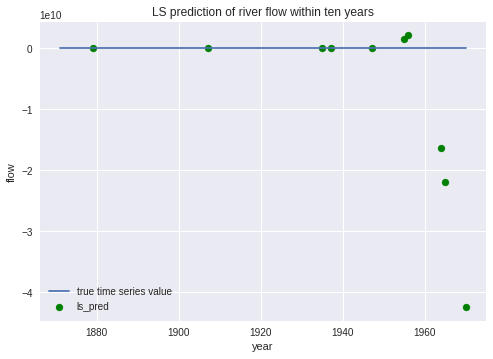

In [ ]:

plt.style.use('seaborn')
plt.scatter(year_missing, ls_pred_missing, label = 'ls_pred', c = 'g')
plt.plot(year, f, label = 'true time series value')
plt.legend()
plt.xlabel('year')
plt.ylabel('flow')
plt.title('LS prediction of river flow within ten years')
plt.show()

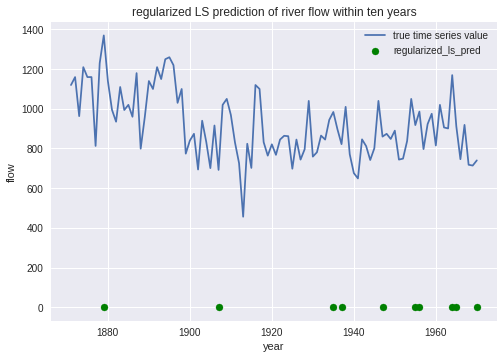

In [ ]:
# fits perfectly
plt.style.use('seaborn')
plt.scatter(year_missing, regularize_ls_pred_miss, label = 'regularized_ls_pred', c='g')
plt.plot(year, f, label = 'true time series value')
plt.legend()
plt.xlabel('year')
plt.ylabel('flow')
plt.title('regularized LS prediction of river flow within ten years')
plt.show()

Observation: the linear square method does a poor job in filling in missing year flow values masked in the dataset. L2 regularization does not helps imporve the prediction result. All of its prediction are close to 0 since the penalization for the norm of x is too large.

## Problem 2
The basis pursuit problem is the following minimization problem:
$$\text{minimize} \quad ||x||_{1} \quad \text{subject to} \quad Ax = b$$
where $A \in R^{m \times n}, x \in R^{n}$ and $b \in R^{m}$, and $||x||_{1} = \sum_{i=1}^{n}|x_i|$. Typically, the linear system $Ax = b$ is underdetermined, so that $m < n$. Note that minimizing $||x||_{1}$ promotes sparsity in x- there will tend to be more zero entries. Our goal will be to solve:
$$\text{minimize} \quad  || \alpha||_{1} \quad \text{subject to} \quad X_{1}\alpha = f_I$$
in order to compute a sparse solution to the underdetermined linear system. 


1. Prove that the basis pursuit problem is equivalent to the following standard form LP:
$$\text{minimize} \quad \sum_{i=1}^{n}u_i + \sum_{i=1}^{n}v_i $$
$$\text{subject to} \quad [\Phi_{I} \quad - \Phi_{I}][u \quad v] = f_{I}$$
$$u \geq 0$$
$$v \geq 0$$




- u is the set of index where the $\leq$ constraint holds, v is the set of index where the = constraint holds. in this case, since there are no $ \leq $ constraints, $u$ is empty set. $u_i = 1$ if $i \in u$ else $u_i =0$, $v_i = 1$ if $i \in v$ else $v_i =0$

- Let $A = \Phi_{I}, b = f_{I}, x = u-v$

$[\Phi_{I} \quad -\Phi_{I}] [u \quad v] = \Phi_{I}(u-v)  =Ax = f_{I} = b$ is the same as the subject to condition $Ax= b$ in equation 3.

-  since $x = u-v$, $||x||_{1} = \sum_{i=1}^{n} x_i =\sum_{i=1}^{n} (u+(-v))_i = \sum_{i=1}^{n} u_i + \sum_{i=1}^{n}v_i  = \sum_{i=1}^{n}v_i  $ The subject condition of two cases are also the same. 


Since the minimization cost function and subject to condition is interchangeable, the basis pursuit problem is equivalent to the standard form LP given in this question.

2. Solve this LP using `scipy.optimize.linprog`.

In [11]:
uv_len = len(f)
c = np.ones(2 * uv_len)
A_eq = np.concatenate((X_I,-X_I),axis=1)
res = linprog(c, A_eq = A_eq, b_eq= f_I)
bounds = [(0,None)]* uv_len
alpha_bp = res.x[:uv_len] - res.x[uv_len:]
print(f'the sparse alpha is: {alpha_bp}')

the sparse alpha is: [ 9.11789587e+03  7.58355228e+02  6.20693357e+02  6.25115332e+01
 -7.37872503e+01 -1.32162826e+02 -2.47277304e+02  2.26779564e+02
  5.56540578e+01  2.74592852e+02  6.72768888e+01 -7.78267138e-08
 -3.19293032e+02 -7.16531977e+01 -2.80112684e+02  1.14014311e+01
  2.51347110e+02  2.73580456e+02  2.58222042e+01 -1.46726276e+01
 -1.82328415e+02  2.01773886e+02  1.93875442e+01 -7.89493398e+01
  4.26082485e+00  1.11305161e+02  3.62723754e+02  2.66766477e+01
 -1.58938028e+02 -1.37448268e+02  2.22714569e+01  1.74298259e+02
 -1.05025653e+02 -3.44962608e+02 -1.63886745e+02  9.20695587e-09
 -5.77415005e+01 -2.46594677e+02  8.67105495e+01  1.64882787e-08
  1.27214442e-08  1.10223712e+02 -5.10914928e+00 -3.33876277e+01
  4.45318040e+01  1.05758444e+02 -5.27139423e+01  2.68173256e+02
  2.62533140e+02  4.16481105e+01  2.66726945e+02  8.54891700e+01
  4.05104356e-08  2.06374839e+02 -1.28804367e+02 -9.82113825e+01
  3.72186490e+01 -1.14672604e+02 -8.50967585e+01 -2.78680649e+01
 -4.

In [12]:
bp_pred = X_dct @ alpha_bp
bp_pred_missing = X_missing @ alpha_bp
print(f'True flow values: {f_missing_target}')
print(f'bp prediction for missing values:{bp_pred_missing}')

True flow values: [ 897.  822. 1160.  960.  958.  838.  744. 1100. 1170.  912.]
bp prediction for missing values:[ 580.44599558  685.95072698  938.53025133 1016.52984583  874.42853418
  823.9113997   872.40342375  958.18082576 1037.71979684 1016.85793583]


3. Compare your results with what you got in Problem 1.

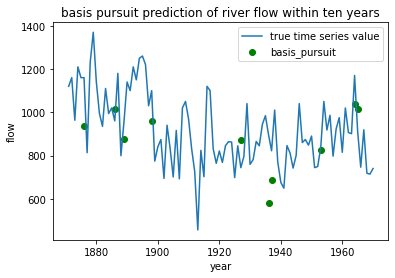

In [13]:
plt.scatter(year_missing, bp_pred_missing, label = 'basis_pursuit', c='g')
plt.plot(year, f, label = 'true time series value')
plt.legend()
plt.xlabel('year')
plt.ylabel('flow')
plt.title('basis pursuit prediction of river flow within ten years')
plt.show()

The sum of absolute value of elements in sparse alpha is smaller than the regularized least square alpha. The prediction is as good as the regularized least square(fits the original missing data perfectly). Since the orthogonal DCT matrix X is construced from the entire f, when some of the datapoints in f and X are missing, we can still reconstruct their values by using optimization methods (using regularized least square or basis pursuit)

## Problem3:
Show that the dual LP of the basis pursuit problem is:
$$\text{maximize} \quad f_{I}^T \lambda$$
$$\text{subject to} \quad -1 \leq \Phi_{I}^T \lambda \leq 1$$
where 1 is a vector with each of its components equal to 1.

It is proved in class that solving the primal LP problem: 
$$\text{minimize} \quad f(x) = c^Tx$$ 
subject to 
$$Ax = b, x \geq 0$$
is equivalent to solving the dual LP problem: 
$$\text{minimize} \quad g(x) = b^T \lambda$$ 
subject to 
$$A^T \lambda + s = c, s \geq 0$$ 
i.e. $A^T \lambda \leq c$

The primal problem is $\text{minimize} \quad ||\alpha||_{i} = c^T \alpha$ subject to $[\Phi_{I} -\Phi_{I}]\alpha = f_{I}$ where $ c^T = [1 1 1 1 ...1], \alpha \geq 0$ 

So it is the same as solving its dual problem $\text{maximize} \quad f_{I}^T \lambda$ subject to $\Phi_{I}^T\lambda \leq c$, which is $\text{maximize} \quad f_{I}^T \lambda$ subject to 
$$[\Phi_{I} \quad -\Phi_{I}]^T \lambda \leq [1,1,1...1]$$
which is the same as $\Phi_{I}^T \lambda \leq 1$ and $\Phi_{I}^T \lambda \geq -1$

The strong duality holds and the minimum of primal problem equals the maximum of the dual problem.


## Problem4
Set up and solve the dual LP for the Nile time series basis pursuit problem. Explain how to recover the primal variables from the dual variables and do so. Check that your results agree.

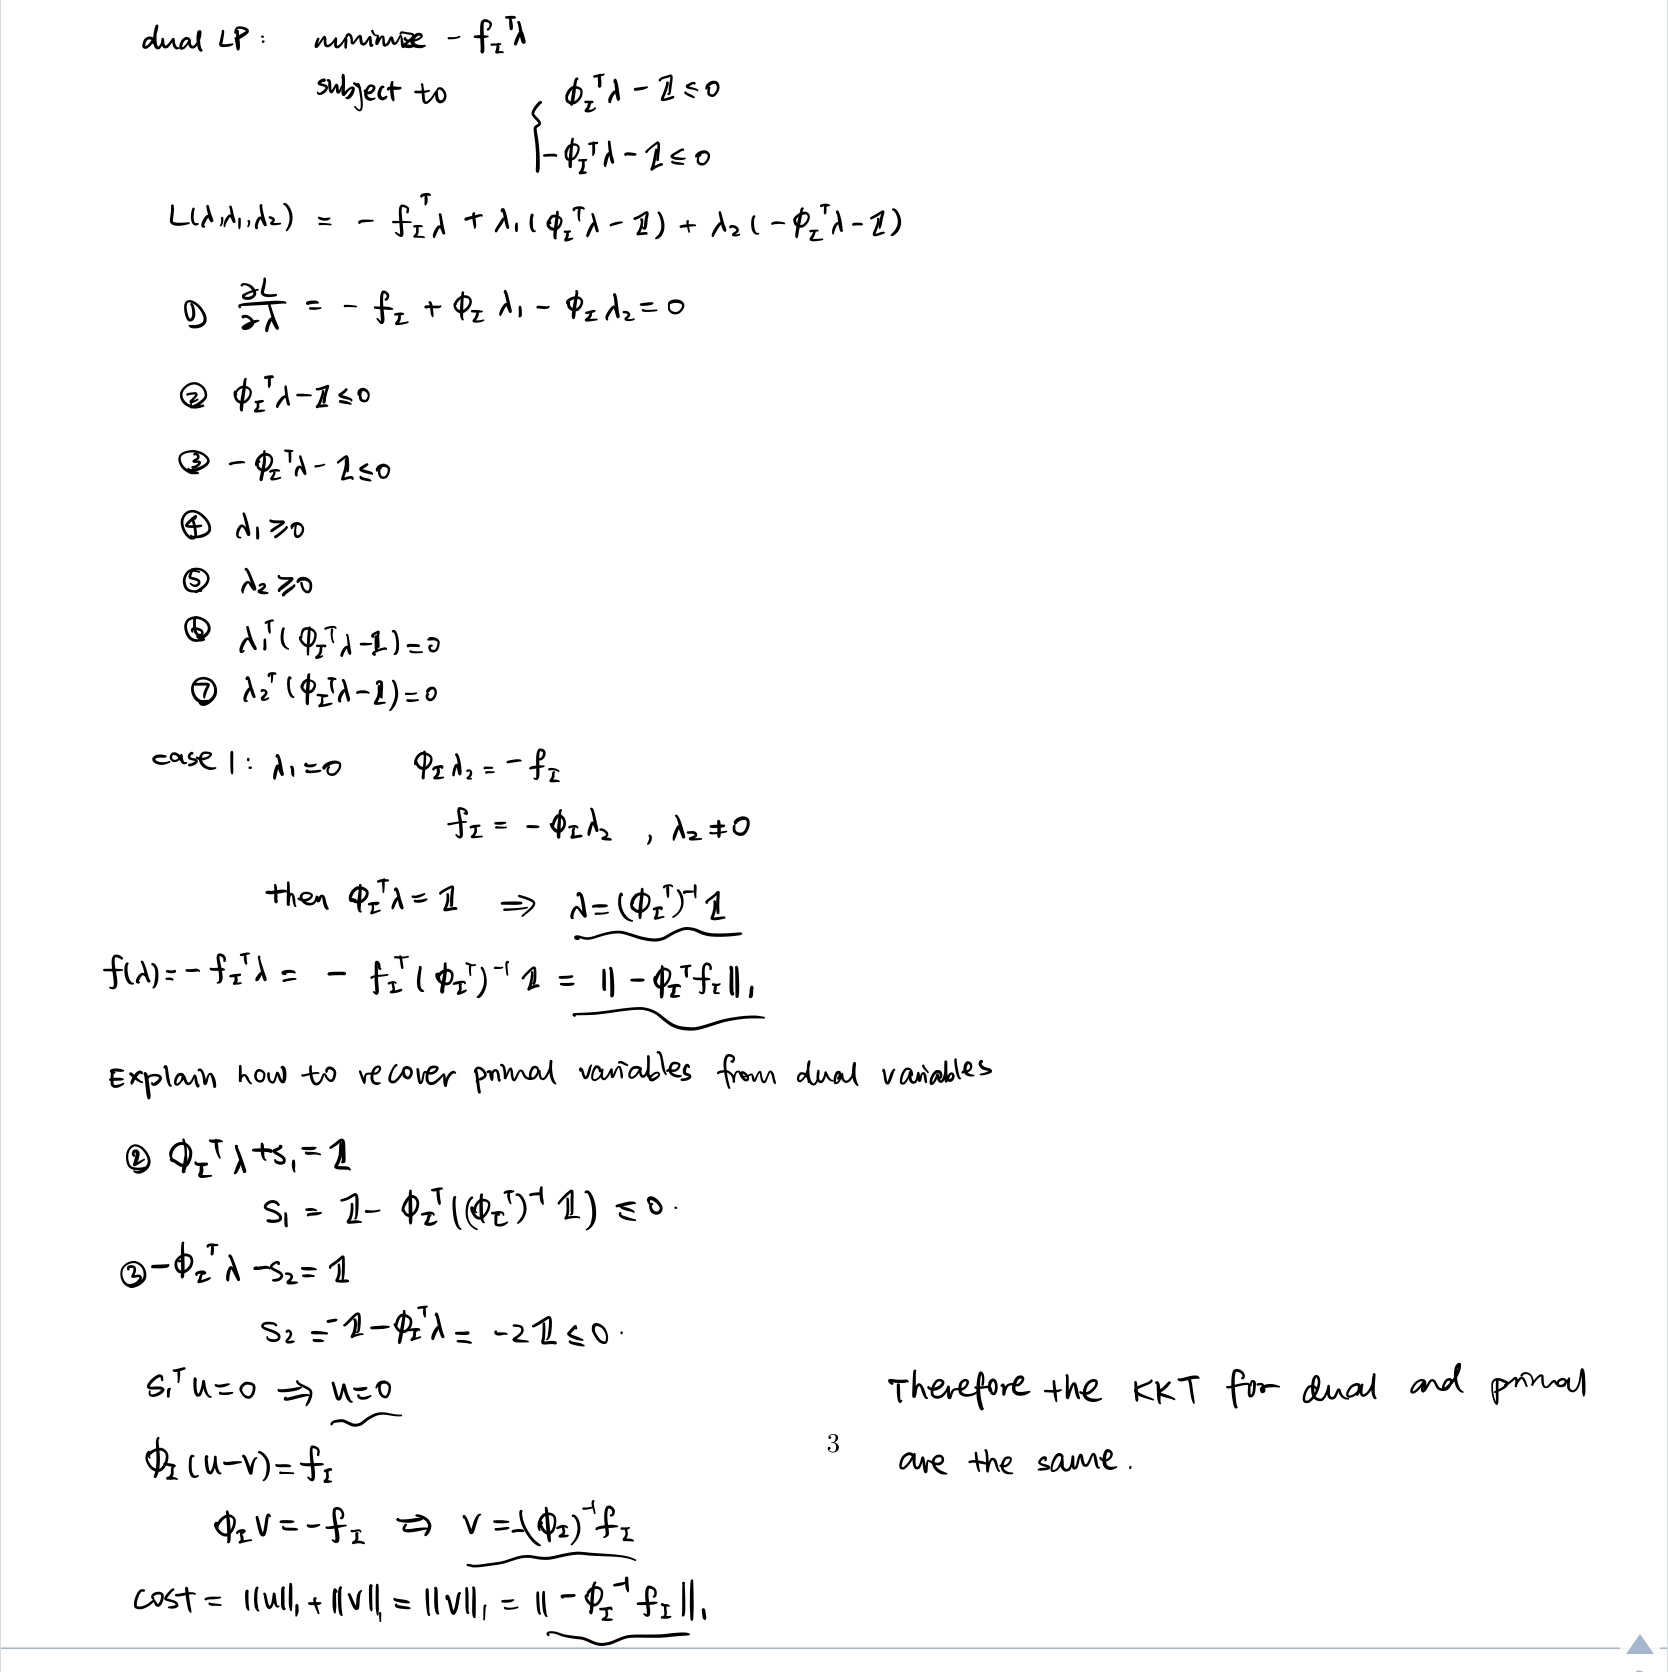

In [ ]:
len_one = len(f)
A_ub = np.concatenate((X_I.T,-X_I.T),axis=0)
b_ub = np.ones(2*len(f))
res = linprog(c, A_ub = A_ub, b_ub= b_ub)
lambda_bp = res.x
minimum_dual = np.dot(-f_I , lambda_bp)
maximum_dual = - minimum_dual
maximum_dual

12392.229331019451

In [ ]:
minimum_primal = np.sum(np.abs(alpha_bp))
minimum_primal 

19952.365343214882

## Bonus Problem

Now we want to use basis pursuit to do image inpainting. We will elliminate a rectangular region from a grayscale image and set up a basis pursuit problem to recover the missing values using the values in a small margin around the rectangle. 
You can get a test image of a aracoon with the following code snippet:
`img = (scipy.misc.face()/255.mean(2))`
You should assume the region we delete consists of indices in the rectangle $[i_0, i_1) \times [j_0, j_1) \subset Z^2$. For recovery, we let $p>0$ and consider the indices:

$$I = ([i_0-p, i_1+p) \times [j_0-p, j_1+p)) \ \ ([i_0, i_1) \times [j_0, j_1)) \subset Z^2$$
As before, we will use the DCT basis. But this time, since we are working with a two-dimensional signal, we wll use a DCT basis for each dimension. This can be accomplished using a Kronecker product. Let $m = i_1 -i_0$ and $n = j_1-j_0$. To set up a 2d DCT basis on an $(m+2p) \times (n+2p)$ grid, use:
`dct = lambda n: scipy.fft.dct(np.eye(n), norm = 'ortho')`
`X = np.kron(dct(m+ 2*p), dct(n+2*p))`
Note very carefully: this assumes a row-major ordering of the grid nodes. Here's hoow the 2d and 1d orderings relate:
`alpha = np.zeros((m + 2*p) * (n+2*p))`
`alpha[alpha.size//8] = np.random.randn(alpha.size//8)`
`f = X @ alpha`
`F = f.reshape(m + 2*p, n+ 2*p)`
`plt.figure()`
`plt.imshow(F)`
`plt.show()`

After setting up and solving the primal basis pursuit problem for inpainting, compare the original and recovered images. Make plots showing what you come up with. Additionally, compute the root mean-squared error and see how it varies for different rectangles and different values of $p$. What do you observe?



In [14]:
import scipy.misc as misc
import numpy as np
from scipy import fft
import matplotlib.pyplot as plt

In [15]:
img = (misc.face()/255).mean(2)
original_img = img.copy()
def rmse(F, original):
  return np.sqrt(np.mean(np.square(F.flatten()- original.flatten())))

In [ ]:
img.shape

(768, 1024)

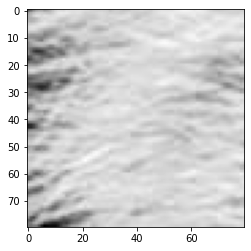

In [ ]:

plt.imshow(original, cmap = 'gray')

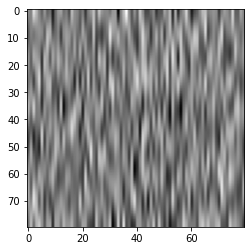

In [ ]:
plt.imshow(F, cmap = 'gray')

In [16]:
def recover(img, p, i0, j0):
  i1 = i0+ 20
  j1 = j0+ 20
  img[i0:i1, j0:j1] = np.zeros((i1-i0, j1-j0))
  m = i1 - i0
  n = j1 - j0
  dct = lambda n : fft.dct(np.eye(n), norm = 'ortho')
  X = np.kron(dct(m + 2*p), dct(n + 2*p))
  alpha = np.zeros((m+2*p)*(n+2*p))
  alpha[:alpha.size//8] = np.random.randn(alpha.size//8)
  f = X@ alpha
  F = f.reshape(m+2*p, n+2*p)
  original = original_img[i0-p:i1+p, j0-p:j1+p]
  root_mse = rmse(F, original)
  return root_mse


In [17]:
coordinates = np.random.randint(100, 700, size = (5,2))
result_dict = {}
for rn in coordinates:
  i0, j0 = rn[0], rn[1]
  p_list = [5,8,10,15,20, 25, 30, 35]
  rmse_list =[]
  for p in p_list:
    rmse_list.append(recover(img, p, i0, j0))
  result_dict[f'{rn[0]},{rn[1]}'] = rmse_list
result_dict

{'615,435': [0.6224467512930139,
  0.586531828604929,
  0.6009631164100897,
  0.5990903099976235,
  0.582526599289538,
  0.604757774452425,
  0.6028455563696005,
  0.5906905998823864],
 '430,224': [0.573954624053548,
  0.5653243018375075,
  0.5452428024002396,
  0.5635543954945142,
  0.5902121614185342,
  0.541500569723958,
  0.5316787784505669,
  0.5531135602789262],
 '184,365': [0.8094240394025944,
  0.8195447766654582,
  0.7882639856188656,
  0.7746226626062115,
  0.802378098083963,
  0.7965145458047466,
  0.7713002275069053,
  0.7587859026886413],
 '433,343': [0.5214479843884312,
  0.5923090931287325,
  0.5498421806037869,
  0.5589571105779537,
  0.5875612167686247,
  0.5736433931809076,
  0.6058345284916075,
  0.602274415204187],
 '520,496': [0.5510634238876886,
  0.5250675131831114,
  0.545626258117734,
  0.595039223882449,
  0.5956702719888227,
  0.5734950657643391,
  0.6014193720298326,
  0.6121317300100628]}

As p increases, the root mean squre error generally decreases,though in some cases first increase then decrease. This suggests that more contextual information helps reconstruct the missing pixel information.

Two more things to experiment with: 

1. Try inpainting a smoother two-dimensional signal. An interesting choice would be a random combination of the columns of X (the 2D DCT basis). In this case, in principla, exact recovery should be possible under certain circumstances.


In [18]:
from scipy.stats import ortho_group


def smoother_recover(img, p, i0, j0):
  i1 = i0+ 20
  j1 = j0+ 20
  original = img[i0-p:i1+p, j0-p:j1+p].copy()
  img[i0:i1, j0:j1] = np.zeros((i1-i0, j1-j0))
  m = i1 - i0
  n = j1 - j0
  dct = lambda n : fft.dct(np.eye(n), norm = 'ortho')
  X = np.kron(dct(m + 2*p), dct(n + 2*p))
  alpha = np.zeros((m+2*p)*(n+2*p))
  alpha[:alpha.size//8] = np.random.randn(alpha.size//8)
  f = X@ alpha
  F = f.reshape(m+2*p, n+2*p)
  root_mse = rmse(F, original)
  return root_mse


# smoother image
img = fft.dct(np.eye(1000), norm = 'ortho') @ ortho_group.rvs(dim=1000)
coordinates= np.random.randint(100, 700, size = (5,2))
smooth_result_dict = {}
for rn in coordinates:
  i0, j0 = rn[0], rn[1]
  p_list = [5,8,10,15,20, 25, 30, 35]
  rmse_list =[]
  for p in p_list:
    rmse_list.append(smoother_recover(img, p, i0, j0))
  smooth_result_dict[f'{rn[0]},{rn[1]}'] = rmse_list
smooth_result_dict

{'309,164': [0.36924828519204933,
  0.3665460004536098,
  0.38937684306336046,
  0.34124106532086573,
  0.3362304337736885,
  0.36195388569643616,
  0.35327469020736535,
  0.36251032282316925],
 '439,284': [0.3455529864363984,
  0.35016335130259907,
  0.34549923516754,
  0.34820285425195,
  0.3663122898698786,
  0.35561108484757054,
  0.35713877947717904,
  0.3392357391273918],
 '499,406': [0.3579592885691368,
  0.36617587875796753,
  0.3480665754695464,
  0.363240925925227,
  0.3587894581972417,
  0.3538116841554977,
  0.3560926817779867,
  0.3602587142601208],
 '446,242': [0.35165431455088775,
  0.3651417159289336,
  0.350215221974243,
  0.3365198757826961,
  0.3483144703248191,
  0.34119533474876584,
  0.352909797552524,
  0.34604468471526006],
 '276,437': [0.3648278863533165,
  0.3428534766137921,
  0.3056213309841138,
  0.36296913824011007,
  0.3567837977721758,
  0.3342122031700797,
  0.3708688707598224,
  0.35504320490176255]}

When using a smoother 2-dimensional signal, the root mean square error is smaller compared to image in the first part. 

2. Try using a basis other than the DCT. A good choice is a 2D Wavelet basis, such as the Haar basis. See, ee.g. this Wikipedia page.

How do the results compare?

In [26]:
def haarMatrix(n, normalized=True):
    # Allow only size n of power 2
    n = 2**np.ceil(np.log2(n))
    if n > 2:
        h = haarMatrix(n / 2)
    else:
        return np.array([[1, 1], [1, -1]])

    # calculate upper haar part
    h_n = np.kron(h, [1, 1])
    # calculate lower haar part 
    if normalized:
        h_i = np.sqrt(n/2)*np.kron(np.eye(len(h)), [1, -1])
    else:
        h_i = np.kron(np.eye(len(h)), [1, -1])
    # combine parts
    h = np.vstack((h_n, h_i))
    return h
haarMatrix(100).shape

(128, 128)

In [ ]:
img  = (misc.face()/255).mean(2)
def haar_recover(img, p, i0, j0):
  i1 = i0+ 20
  j1 = j0+ 20
  original = img[i0-p:i1+p, j0-p:j1+p].copy()
  img[i0:i1, j0:j1] = np.zeros((i1-i0, j1-j0))
  m = i1 - i0
  n = j1 - j0
  haar = lambda n : haarMatrix(n)
  X = np.kron(haar(m + 2*p), haar(n + 2*p))
  alpha = np.zeros((m+2*p)*(n+2*p))
  alpha[:alpha.size//8] = np.random.randn(alpha.size//8)
  print(len(alpha))
  f = X @ alpha
  F = f.reshape(m+2*p, n+2*p)
  root_mse = rmse(F, original)
  return root_mse

coordinates= np.random.randint(100, 700, size = (5,2))
haar_result_dict = {}
for rn in coordinates:
  i0, j0 = rn[0], rn[1]
  p_list = [5,8,10,15,20, 25, 30, 35]
  rmse_list =[]
  for p in p_list:
    rmse_list.append(haar_recover(img, p, i0, j0))
  haar_result_dict[f'{rn[0]},{rn[1]}'] = rmse_list
haar_result_dict

900


ValueError: ignored